In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

import os
import random
import pickle
from collections import Counter

import pandas as pd
import numpy as np

from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve

# default plot stying changes
import seaborn as sns
sns.set_style("white")
sns.set_context("poster", font_scale=1.25, rc={"lines.linewidth": 2.5})
sns.set_palette("Set2")
colors = sns.color_palette('Set2',12)

import warnings
warnings.filterwarnings('ignore')

# Load Pickled Labels

In [2]:
directory = 'generated_data'
if not os.path.exists(directory):
    os.makedirs(directory)

train_labels = np.load('{0}/train_labels.dat'.format(directory))
test_labels = np.load('{0}/test_labels.dat'.format(directory))
print('Training labels shape: {0}'.format(train_labels.shape))
print('Testing labels shape:  {0}'.format(test_labels.shape))

Training labels shape: (7326,)
Testing labels shape:  (2603,)


# Load Otsu's Binarization Threshold Data

In [3]:
train_OBT_2d = np.load('{0}/train_OBT_2d.dat'.format(directory))
test_OBT_2d = np.load('{0}/test_OBT_2d.dat'.format(directory))
print('Otsu training shape: {0}'.format(train_OBT_2d.shape))
print('Otsu testing shape:  {0}'.format(test_OBT_2d.shape))

Otsu training shape: (7326, 640)
Otsu testing shape:  (2603, 640)


# Load Adaptive Mean Threshold Data

In [4]:
train_AMT_2d = np.load('{0}/train_AMT_2d.dat'.format(directory))
test_AMT_2d = np.load('{0}/test_AMT_2d.dat'.format(directory))
print('Adaptive mean training shape: {0}'.format(train_AMT_2d.shape))
print('Adaptive mean testing shape:  {0}'.format(test_AMT_2d.shape))

Adaptive mean training shape: (7326, 640)
Adaptive mean testing shape:  (2603, 640)


# Load Adaptive Gaussian Threshold Data

In [5]:
train_AGT_2d = np.load('{0}/train_AGT_2d.dat'.format(directory))
test_AGT_2d = np.load('{0}/test_AGT_2d.dat'.format(directory))
print('Adaptive Gaussian training shape: {0}'.format(train_AGT_2d.shape))
print('Adaptive Gaussian testing shape:  {0}'.format(test_AGT_2d.shape))

Adaptive Gaussian training shape: (7326, 640)
Adaptive Gaussian testing shape:  (2603, 640)


# Load Principle Component Analysis Data

In [6]:
train_PCA_2d = np.load('{0}/train_PCA_2d.dat'.format(directory))
test_PCA_2d = np.load('{0}/test_PCA_2d.dat'.format(directory))
print('PCA training shape: {0}'.format(train_PCA_2d.shape))
print('PCA testing shape:  {0}'.format(test_PCA_2d.shape))

PCA training shape: (7326, 40)
PCA testing shape:  (2603, 40)


# Lists of Datasets

In [7]:
names = ['OBT', 'AMT', 'AGT', 'PCA']
# extended names for readability
names_ext = ['Otsu', 'Adapt. Mean', 'Adapt. Gaussian', 'PCA']
l_train = [train_OBT_2d, train_AMT_2d, train_AGT_2d, train_PCA_2d]
l_test = [test_OBT_2d, test_AMT_2d, test_AGT_2d, test_PCA_2d]
overall_dict = {}

# Visualize Important Pixels

In [8]:
img_dir = 'imgs'
if not os.path.exists(img_dir):
    os.makedirs(img_dir)
    
def important_pixels(mdl, save_img, ht=32, wd=20):
    '''
    source: http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances_faces. \
                            html#example-ensemble-plot-forest-importances-faces-py
    '''
    importances = mdl.feature_importances_
    try:
        importances = importances.reshape(ht,wd)

        # Plot pixel importances
        plt.matshow(importances, cmap=plt.cm.hot)
        plt.axis('off')
        plt.savefig('{0}/{1}'.format(img_dir, save_img), bbox_inches='tight')
    except:
        pass

# Model Folder

In [9]:
mdl_dir = 'models'
if not os.path.exists(mdl_dir):
    os.makedirs(mdl_dir)

# Ada Boost Classifier

In [10]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier

# Attributes
# estimators_ : list of classifiers
# classes_ : array of shape = [n_classes]
# n_classes_ : int
# estimator_weights_ : array of floats
# estimator_errors_ : array of floats
# feature_importances_ : array of shape = [n_features]

ab_dict = {}

for i,dataset in enumerate(l_train):

    etr_clf = ExtraTreesClassifier(n_estimators=50, criterion='gini', max_depth=None, min_samples_split=4, 
                    min_samples_leaf=2, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, 
                    bootstrap=False, oob_score=False, n_jobs=-1, random_state=None, verbose=0, warm_start=False, 
                    class_weight=None)
    
    ab_clf = AdaBoostClassifier(base_estimator=etr_clf, n_estimators=50, learning_rate=0.1, 
                                 algorithm='SAMME.R', random_state=None)
    
    # cross-validation training score
    scores = cross_val_score(ab_clf, dataset, train_labels)
    
    # append results to dictionary
    ab_dict[('{0}'.format(names[i]))] = scores.mean()*100
    
    # models - save to disk for later use without re-running
    ab_mdl = ab_clf.fit(dataset, train_labels) 
    
    with open('{0}/ada_boost_{1}.pkl'.format(mdl_dir, names[i]), 'wb') as f:
        pickle.dump(ab_mdl, f)  
    
    # un-comment to get pixel importance images
    # important_pixels(ab_mdl, 'ada_boost_{0}'.format(names[i]))

In [11]:
overall_dict['ada_boost'] = ab_dict
ab_dict

{'AGT': 65.465002713079571,
 'AMT': 70.364333726592761,
 'OBT': 69.340563686822023,
 'PCA': 54.012240821076105}

# Bagging Classifier

In [12]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier

# Attributes
# base_estimator_ : list of estimators
# estimators_ : list of estimators
# estimators_samples_ : list of arrays
# estimators_features_ : list of arrays
# classes_ : array of shape = [n_classes]
# n_classes_ : int or list
# oob_score_ : float
# oob_decision_function_ : array of shape = [n_samples, n_classes]

bag_dict = {}

for i,dataset in enumerate(l_train):
    
    etr_clf = ExtraTreesClassifier(n_estimators=50, criterion='gini', max_depth=None, min_samples_split=4, 
                    min_samples_leaf=2, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, 
                    bootstrap=False, oob_score=False, n_jobs=-1, random_state=None, verbose=0, warm_start=False, 
                    class_weight=None)
    
    bag_clf = BaggingClassifier(base_estimator=etr_clf, n_estimators=50, max_samples=1.0, max_features=1.0, 
                                bootstrap=True, bootstrap_features=False, oob_score=False, warm_start=False, 
                                n_jobs=-1, random_state=None, verbose=0)
    # cross-validation training score
    scores = cross_val_score(bag_clf, dataset, train_labels)
    
    # append results to dictionary
    bag_dict['{0}'.format(names[i])] = scores.mean()*100
    
    # models - save to disk for later use without re-running
    bag_mdl = bag_clf.fit(dataset, train_labels) 
    
    with open('{0}/bagging_{1}.pkl'.format(mdl_dir, names[i]), 'wb') as f:
        pickle.dump(bag_mdl, f)  

In [13]:
overall_dict['bagging'] = bag_dict
bag_dict

{'AGT': 68.590119006915955,
 'AMT': 72.616524330366602,
 'OBT': 67.838601446830609,
 'PCA': 54.191430292289802}

# Gradient Boosting Classifier - TAKES A LONG TIME TO RUN

In [14]:
from sklearn.ensemble import GradientBoostingClassifier

# Attributes
# feature_importances_ : array, shape = [n_features]
# oob_improvement_ : array, shape = [n_estimators]
# train_score_ : array, shape = [n_estimators]
# loss_ : LossFunction
# init : BaseEstimator
# estimators_ : ndarray of DecisionTreeRegressor, shape = [n_estimators, loss_.K]
    
gb_dict = {}

n_estimators=300

# min_samples_split => 0.5%-1% of total values
min_samples_split = round(0.005*len(train_labels))

# min_samples_leaf => 50
min_samples_leaf = 50

# max_depth => between 5-8
max_depth = 6

# max_features => 'sqrt' as a rule of thumb to start
max_features = 'sqrt'

# subsample => 0.8 to start
subsample = 0.5

for i,dataset in enumerate(l_train):
    gb_clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=n_estimators, 
                                    subsample=subsample, min_samples_split=min_samples_split, 
                                    min_samples_leaf=min_samples_leaf, max_depth=max_depth, init=None, 
                                    random_state=None, max_features=max_features, verbose=0, 
                                    max_leaf_nodes=None, warm_start=False, presort='auto')
    # cross-validation training score
    scores = cross_val_score(gb_clf, dataset, train_labels)
    
    # append results to dictionary
    gb_dict[('{0}'.format(names[i]))] = scores.mean()*100
    
    # models - save to disk for later use without re-running
    gb_mdl = gb_clf.fit(dataset, train_labels)
    
    with open('{0}/gradient_boost_{1}.pkl'.format(mdl_dir, names[i]), 'wb') as f:
        pickle.dump(gb_mdl, f)  
    
    # un-comment to get pixel importance images
    # important_pixels(gb_mdl, 'gradient_boost_{0}'.format(names[i]))

In [15]:
overall_dict['gradient_boost'] = gb_dict
gb_dict

{'AGT': 71.538043448957609,
 'AMT': 74.814272343448323,
 'OBT': 67.948846842623539,
 'PCA': 64.700360246641239}

# Extra Trees Classifier

In [16]:
from sklearn.ensemble import ExtraTreesClassifier

etr_dict = {}

for i,dataset in enumerate(l_train):
    
    etr_clf = ExtraTreesClassifier(n_estimators=400, criterion='gini', max_depth=None, min_samples_split=4, 
                    min_samples_leaf=2, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, 
                    bootstrap=False, oob_score=False, n_jobs=-1, random_state=None, verbose=0, warm_start=False, 
                    class_weight=None)
    
    # cross-validation training score
    scores = cross_val_score(etr_clf, dataset, train_labels)
    
    # append results to dictionary
    etr_dict['{0}'.format(names[i])] = scores.mean()*100
    
    # models - save to disk for later use without re-running
    etr_mdl = etr_clf.fit(dataset, train_labels)
    
    with open('{0}/extra_trees_{1}.pkl'.format(mdl_dir, names[i]), 'wb') as f:
        pickle.dump(etr_mdl, f)  
    
    # un-comment to get pixel importance images
    # important_pixels(etr_mdl, 'extra_tree{0}'.format(names[i]))

In [17]:
overall_dict['extra_trees'] = etr_dict
etr_dict

{'AGT': 70.78736238080225,
 'AMT': 74.063239226827491,
 'OBT': 68.753316608888497,
 'PCA': 57.972437255021582}

In [18]:
etr_clf = ExtraTreesClassifier()
etr_mdl = etr_clf.fit(train_AMT_2d, train_labels)
print(classification_report(test_labels, etr_clf.predict(test_AMT_2d), digits=2))

             precision    recall  f1-score   support

          0       0.43      0.53      0.47       180
          1       0.65      0.83      0.73       509
          2       0.59      0.70      0.64       394
          3       0.46      0.48      0.47       295
          4       0.56      0.56      0.56       256
          5       0.55      0.52      0.53       231
          6       0.49      0.35      0.41       199
          7       0.65      0.53      0.59       202
          8       0.55      0.24      0.33       175
          9       0.51      0.27      0.35       162

avg / total       0.56      0.56      0.55      2603



# Random Forrest Classifier

In [19]:
from sklearn.ensemble import RandomForestClassifier

# Attributes
# estimators_ : list of DecisionTreeClassifier
# classes_ : array of shape = [n_classes] or a list of such arrays
# n_classes_ : int or list
# n_features_ : int
# n_outputs_ : int
# feature_importances_ : array of shape = [n_features]
# oob_score_ : float
# oob_decision_function_ : array of shape = [n_samples, n_classes]
    
rf_dict = {}

for i,dataset in enumerate(l_train):
    rf_clf = RandomForestClassifier(n_estimators=150, criterion='gini', max_depth=None, min_samples_split=2, 
                                min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', 
                                max_leaf_nodes=None, bootstrap=True, oob_score=False, n_jobs=-1, random_state=None, 
                                verbose=0, warm_start=False, class_weight=None)

    # cross-validation training score
    scores = cross_val_score(rf_clf, dataset, train_labels)
    
    # append results to dictionary
    rf_dict['{0}'.format(names[i])] = scores.mean()*100
    
    # models - save to disk for later use without re-running
    rf_mdl = rf_clf.fit(dataset, train_labels)
    
    with open('{0}/random_forrest_{1}.pkl'.format(mdl_dir, names[i]), 'wb') as f:
        pickle.dump(rf_mdl, f)  
    
    # un-comment to get pixel importance images
    # important_pixels(rf_mdl, 'random_forrest{0}'.format(names[i]))

In [20]:
overall_dict['random_forrest'] = rf_dict
rf_dict

{'AGT': 66.733920586248189,
 'AMT': 71.059849271052315,
 'OBT': 67.238764728383458,
 'PCA': 59.951721980948633}

# KNN

In [21]:
from sklearn.neighbors import KNeighborsClassifier
    
knn_dict = {}

for i,dataset in enumerate(l_train):
    knn_clf = KNeighborsClassifier(n_neighbors=10, weights='uniform', algorithm='auto', leaf_size=30, p=2, 
                                   metric='minkowski', metric_params=None, n_jobs=-1)

    # cross-validation training score
    scores = cross_val_score(knn_clf, dataset, train_labels)
    
    # append results to dictionary
    knn_dict['{0}'.format(names[i])] = scores.mean()*100
    
    # models - save to disk for later use without re-running
    knn_mdl = knn_clf.fit(dataset, train_labels)
    
    with open('{0}/kneighbors_{1}.pkl'.format(mdl_dir, names[i]), 'wb') as f:
        pickle.dump(knn_mdl, f)  

In [22]:
overall_dict['kneighbors'] = knn_dict
knn_dict

{'AGT': 60.742378737080713,
 'AMT': 63.82636031674128,
 'OBT': 57.139520969711967,
 'PCA': 61.683895836072068}

# SVM Classifier

In [ ]:
from sklearn.svm import SVC

svc_dict = {}

C = [1, 10, 100]
gamma = [0.1, 0.01, 0.01, 0.001]

for i,dataset in enumerate(l_train):
    for c in C:
        for g in gamma:
            svc_clf = SVC(C=c, kernel='rbf', degree=3, gamma=g, coef0=0.0, shrinking=True, probability=False, 
                          tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, 
                          decision_function_shape=None)

            # cross-validation training score
            scores = cross_val_score(svc_clf, dataset, train_labels)

            # append results to dictionary
            svc_dict[('{0}'.format(names[i]), c, g)] = scores.mean()*100

            # models - save to disk for later use without re-running
            svc_mdl = svc_clf.fit(dataset, train_labels)

            with open('{0}/svc_{1}-{2}-{3}.pkl'.format(mdl_dir, names[i], c, g), 'wb') as f:
                pickle.dump(svc_mdl, f)  

In [25]:
overall_dict['svc'] = svc_dict
svc_dict

{('AGT', 1, 0.001): 19.178291874734157,
 ('AGT', 1, 0.01): 19.178291874734157,
 ('AGT', 1, 0.1): 19.178291874734157,
 ('AGT', 10, 0.001): 19.178291874734157,
 ('AGT', 10, 0.01): 19.178291874734157,
 ('AGT', 10, 0.1): 19.178291874734157,
 ('AGT', 100, 0.001): 19.178291874734157,
 ('AGT', 100, 0.01): 19.178291874734157,
 ('AGT', 100, 0.1): 19.178291874734157,
 ('AMT', 1, 0.001): 19.178291874734157,
 ('AMT', 1, 0.01): 19.178291874734157,
 ('AMT', 1, 0.1): 19.178291874734157,
 ('AMT', 10, 0.001): 19.178291874734157,
 ('AMT', 10, 0.01): 19.178291874734157,
 ('AMT', 10, 0.1): 19.178291874734157,
 ('AMT', 100, 0.001): 19.178291874734157,
 ('AMT', 100, 0.01): 19.178291874734157,
 ('AMT', 100, 0.1): 19.178291874734157,
 ('OBT', 1, 0.001): 19.178291874734157,
 ('OBT', 1, 0.01): 19.178291874734157,
 ('OBT', 1, 0.1): 19.178291874734157,
 ('OBT', 10, 0.001): 19.178291874734157,
 ('OBT', 10, 0.01): 19.178291874734157,
 ('OBT', 10, 0.1): 19.178291874734157,
 ('OBT', 100, 0.001): 19.178291874734157,
 

In [26]:
list(overall_dict.items())

[('random_forrest',
  {'AGT': 66.733920586248189,
   'AMT': 71.059849271052315,
   'OBT': 67.238764728383458,
   'PCA': 59.951721980948633}),
 ('gradient_boost',
  {'AGT': 71.538043448957609,
   'AMT': 74.814272343448323,
   'OBT': 67.948846842623539,
   'PCA': 64.700360246641239}),
 ('extra_trees',
  {'AGT': 70.78736238080225,
   'AMT': 74.063239226827491,
   'OBT': 68.753316608888497,
   'PCA': 57.972437255021582}),
 ('bagging',
  {'AGT': 68.590119006915955,
   'AMT': 72.616524330366602,
   'OBT': 67.838601446830609,
   'PCA': 54.191430292289802}),
 ('ada_boost',
  {'AGT': 65.465002713079571,
   'AMT': 70.364333726592761,
   'OBT': 69.340563686822023,
   'PCA': 54.012240821076105}),
 ('svc',
  {('AGT', 1, 0.001): 19.178291874734157,
   ('AGT', 1, 0.01): 19.178291874734157,
   ('AGT', 1, 0.1): 19.178291874734157,
   ('AGT', 10, 0.001): 19.178291874734157,
   ('AGT', 10, 0.01): 19.178291874734157,
   ('AGT', 10, 0.1): 19.178291874734157,
   ('AGT', 100, 0.001): 19.178291874734157,
   (

In [27]:
# get model names
mdls = [k for k,v in overall_dict.items()]

# get cross fold scores for each model
lst_cnts = [[v for k,v in overall_dict[mdl].items()] for mdl in mdls]

ValueError: incompatible sizes: argument 'height' must be length 5 or scalar

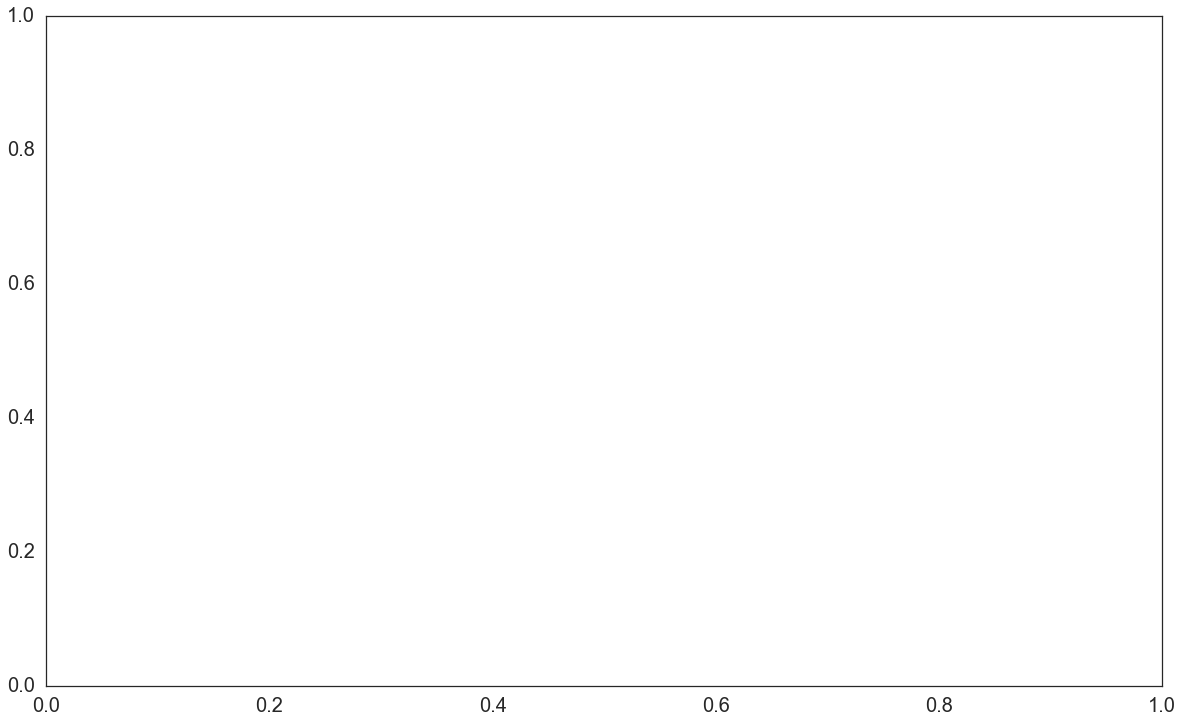

In [30]:
# colors
sns.set_palette("hot")
colors = sns.color_palette('hot',9)

# make figure
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(111)

# spacing/size
width = 0.1
steps = [-0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4]
pos = []
for j in steps:
    temp = []
    for k in range(1,6):
        temp.append(k+j)
    pos.append(temp)
pos

# plots
for i in range(9):
    plt.bar(pos[i], lst_cnts[i], width=width, align='center', color=colors[i], alpha=0.8, edgecolor='w', 
            label=mdls[i])

# labels/titles
plt.legend(loc="best")
plt.xlabel('Threshold Technique')
plt.ylabel('CFV Score')
plt.title('Accuracy by Model and Threshold')

ticks = range(1,6)
plt.xlim(0.5,5.5)
plt.xticks(ticks, names_ext)
plt.ylim(0,100)

# remove border
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 
ax.spines["bottom"].set_visible(False) 
ax.spines["left"].set_visible(False)

# show grid
ax.yaxis.grid(True) 

# plot that biddy
plt.tight_layout()
_ = plt.show()

In [31]:
df = pd.DataFrame(overall_dict)
df

,ada_boost,bagging,extra_trees,gradient_boost,kneighbors,random_forrest,svc
AGT,65.465003,68.590119,70.787362,71.538043,60.742379,66.733921,NaN
AMT,70.364334,72.616524,74.063239,74.814272,63.826360,71.059849,NaN
OBT,69.340564,67.838601,68.753317,67.948847,57.139521,67.238765,NaN
PCA,54.012241,54.191430,57.972437,64.700360,61.683896,59.951722,NaN
"(OBT, 1, 0.1)",NaN,NaN,NaN,NaN,NaN,NaN,19.178292
"(OBT, 10, 0.001)",NaN,NaN,NaN,NaN,NaN,NaN,19.178292
"(AMT, 1, 0.1)",NaN,NaN,NaN,NaN,NaN,NaN,19.178292
"(OBT, 10, 0.1)",NaN,NaN,NaN,NaN,NaN,NaN,19.178292
"(OBT, 1, 0.001)",NaN,NaN,NaN,NaN,NaN,NaN,19.178292
"(AMT, 100, 0.01)",NaN,NaN,NaN,NaN,NaN,NaN,19.178292


In [ ]:
# make figure
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(111)

# plots
ax = sns.heatmap(df, annot=True, cmap="hot_r", alpha=0.8, linewidths=.1, vmin=0, vmax=100)

# labels/titles
plt.title('Accuracy by Model and Threshold')

# remove border
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 
ax.spines["bottom"].set_visible(False) 
ax.spines["left"].set_visible(False)

# show grid
ax.yaxis.grid(False) 

# plot that biddy
plt.tight_layout()
_ = plt.show()

In [47]:
import re
'''
word = 'fubar'
reg_agt = re.compile(r'AGT')
if reg_agt.search(word) is not None:
  print 'matched'
'''
# l_test = [test_OBT_2d, test_AMT_2d, test_AGT_2d, test_PCA_2d]

with open('tuned_resuts.csv', 'a') as f:

    for fil in os.listdir('models'):
        if fil[-3:] == 'pkl':

            reg_agt = re.compile(r'AGT')
            if reg_agt.search(fil) is not None:
                #AGT
                with open('models/{0}'.format(fil), 'rb') as fid:
                    mdl = pickle.load(fid)
                    score = accuracy_score(test_labels, mdl.predict(test_AGT_2d))
                    f.write('{0}, {1}\n'.format(fil[:-4], score))
                    clf = None

            reg_agt = re.compile(r'AMT')
            if reg_agt.search(fil) is not None:
                #AMT
                with open('models/{0}'.format(fil), 'rb') as fid:
                    mdl = pickle.load(fid)
                    score = accuracy_score(test_labels, mdl.predict(test_AMT_2d))
                    f.write('{0}, {1}\n'.format(fil[:-4], score))
                    clf = None

            reg_pca = re.compile(r'PCA')
            if reg_pca.search(fil) is not None:
                #PCA
                with open('models/{0}'.format(fil), 'rb') as fid:
                    mdl = pickle.load(fid)
                    score = accuracy_score(test_labels, mdl.predict(test_PCA_2d))
                    f.write('{0}, {1}\n'.format(fil[:-4], score))
                    clf = None

            reg_obt = re.compile(r'OBT')
            if reg_obt.search(fil) is not None:
                #OBT
                with open('models/{0}'.format(fil), 'rb') as fid:
                    mdl = pickle.load(fid)
                    score = accuracy_score(test_labels, mdl.predict(test_OBT_2d))
                    f.write('{0}, {1}\n'.format(fil[:-4], score))
                    clf = None

In [58]:
df = pd.read_csv('tuned_resuts.csv',  names=['mdl', 'accuracy'])
df = df.sort_values('accuracy', ascending=False)
df.head(10)

,mdl,accuracy
13,gradient_boost_AMT,0.719939
9,extra_trees_AMT,0.711103
5,bagging_AMT,0.699193
12,gradient_boost_AGT,0.689589
21,random_forrest_AMT,0.683826
8,extra_trees_AGT,0.678448
1,ada_boost_AMT,0.667307
4,bagging_AGT,0.657703
2,ada_boost_OBT,0.656166
14,gradient_boost_OBT,0.651556


In [16]:
fid = open('models/gradient_boost_AMT.pkl', 'rb')
mdl = pickle.load(fid)

print(classification_report(test_labels, mdl.predict(test_AMT_2d)))

             precision    recall  f1-score   support

          0       0.75      0.66      0.70       180
          1       0.78      0.87      0.82       509
          2       0.72      0.85      0.78       394
          3       0.61      0.63      0.62       295
          4       0.73      0.72      0.73       256
          5       0.67      0.72      0.69       231
          6       0.63      0.59      0.61       199
          7       0.79      0.68      0.73       202
          8       0.77      0.51      0.61       175
          9       0.73      0.58      0.65       162

avg / total       0.72      0.72      0.72      2603



In [15]:
from sklearn.ensemble import GradientBoostingClassifier

# Attributes
# feature_importances_ : array, shape = [n_features]
# oob_improvement_ : array, shape = [n_estimators]
# train_score_ : array, shape = [n_estimators]
# loss_ : LossFunction
# init : BaseEstimator
# estimators_ : ndarray of DecisionTreeRegressor, shape = [n_estimators, loss_.K]
    
gb_dict = {}

n_estimators=300

# min_samples_split => 0.5%-1% of total values
min_samples_split = round(0.005*len(train_labels))

# min_samples_leaf => 50
min_samples_leaf = 50

# max_depth => between 5-8
max_depth = 6

# max_features => 'sqrt' as a rule of thumb to start
max_features = 'sqrt'

# subsample => 0.8 to start
subsample = 0.5


gb_clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=n_estimators, 
                                subsample=subsample, min_samples_split=min_samples_split, 
                                min_samples_leaf=min_samples_leaf, max_depth=max_depth, init=None, 
                                random_state=None, max_features=max_features, verbose=0, 
                                max_leaf_nodes=None, warm_start=False, presort='auto')

# cross-validation training score
scores = cross_val_score(gb_clf, train_AMT_2d, train_labels)

gb_mdl = gb_clf.fit(train_AMT_2d, train_labels)

In [20]:
p_pred = gb_mdl.predict_proba(test_AMT_2d)
y_test_predicted = gb_mdl.predict(test_AMT_2d)

In [24]:
roc_auc_score(test_labels, p_pred[:, 1])

ValueError: multiclass format is not supported

In [21]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(test_labels, p_pred[:, 1])

ValueError: Data is not binary and pos_label is not specified

In [10]:

print(roc_auc_score(test_labels, mdl.predict(test_AMT_2d)))

In [ ]:
fid.close()